In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#path 
datafile = "/content/drive/MyDrive/Colab Notebooks/data mining/topic_detection_train.v1.0.txt"
savefile = "/content/drive/MyDrive/Colab Notebooks/data mining/topic_detection_train"
stopwordsfile = "/content/drive/MyDrive/Colab Notebooks/data mining/stopwords.txt"

cleandf = "/content/drive/MyDrive/Colab Notebooks/data mining/"

#import

In [3]:
!pip install emoji
!pip install fastBPE
!pip install fairseq
!pip install vncorenlp
!pip install transformers

     |████████████████████████████████| 170 kB 4.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=7070b61eda85bdc3be1636cf37a5acd0a1d16d9f8ba2369077cd1a9ec4899dac
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483111 sha256=d6085578d715e20b970f1cfbe84a137d2933b1f8e91a20aa93cf7cc20bfffea3
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE
     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 145 kB 62.0 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 112 kB 52.4 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
  Created wheel for a

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=fc15ba469f7d796bbdd8986d6c315543ba0c6eb7bfe0ab0612a6de2fea9e0c9c
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
     |████████████████████████████████| 3.1 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
     |████████████████████████████████| 3.3 MB 47.3 MB/s 
     |████████████████████████████████| 61 kB 432 kB/s 


In [4]:
import pandas as pd
import emoji
import tqdm
import re
import string
import random
import numpy as np

In [5]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel
from transformers import get_linear_schedule_with_warmup
from vncorenlp import VnCoreNLP

#**Preprocessing the raw text**

This involves the following:

*   Normalize text: remove some bad word -> khoẻ -> khỏe, ko->không... (done)
*   Tokenization: Split the text into sentences and the sentences into words. (done)
*   Lowercase the words and remove punctuation. (done)
*   Removing stopwords (done)
*   Augment data(done)
*   Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present. (to do)
*   Words are stemmed — words are reduced to their root form. (to do)

In [6]:
acronyms  = {}
with open("/content/drive/MyDrive/Colab Notebooks/data mining/hardword.txt", "r", encoding='utf-8') as f:
  for line in f:
    tmp = line.split(":")
    acronyms[tmp[0]] = tmp[1].strip().lower() 

In [7]:
#@title stopwords
stopwords = []
with open("/content/drive/MyDrive/Colab Notebooks/data mining/stopwords.txt", "r", encoding='utf-8') as f:
  for line in f:
    stopwords.append(line.strip().lower())
d={}
for t in stopwords:
    if len(t) in d.keys():
        d[len(t)].append(t)
    else:
        d[len(t)] = [t]
stopwords = []
for x in d.keys():
    d[x].extend(stopwords)
    stopwords = d[x]

In [8]:
#@title chuẩn hóa dấu
replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa', 
        'qủa':'quả', 'qùa':'quà', 'qủ':'qu', 'qù':'qu', 'qũ':'qu', 'qú':'qu', 'qụ':'qu',
        'ố': 'ố', 'u´': 'ố', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        }

In [27]:
#@title normalize text function
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/Colab Notebooks/data mining/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
def normalize_text(text, remove_stopword=False):
    #Remove link
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'www\S+', '', text, flags=re.MULTILINE)
    #chuyen punctuation thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    # Chuyển thành chữ thường
    text = text.lower()
    #xử lý phụ âm lỗi
    for k, v in replace_list.items():
        text = text.replace(k, v) 
    #xử lý viết tắt
    texts = text.split()
    texts = [acronyms[t] if t in acronyms.keys() else t for t in texts]
    text = u' '.join(texts)

    #loại bỏ từ vô nghĩa, viết tắt(còn lại), một số từ nước ngoài,...
    def _non_nguyen_am(text):
        phu_am = "đ f w j z b c d f g h j k l m n p q r s t v w x z".split(" ")
        for char in text:
            if char not in phu_am:
                return False
        return True
    def fwjz(text):
        for char in text:
            if char in ['f', 'w', 'j', 'z']:
                return True
        return False

    texts = text.split()
    chars = [t for t in texts if fwjz(t) or not t.isalpha() or _non_nguyen_am(t) or len(t)>5]
    texts = [t for t in texts if t not in chars]
    text = u' '.join(texts)

    #word senmentation
    texts = rdrsegmenter.tokenize(text) 
    texts = [" ".join(sentence)  for sentence in texts]
    text = u' '.join(texts)

    #remove nốt những ký tự thừa thãi
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')
    
    if remove_stopword:
        for t in stopwords:
            if t == 'ý':continue
            text = " {} ".format(text).replace(" "+t+" ", ' ')
    
    return text.strip(), chars

In [45]:
#@title clean_text_main_function
def clean_text(rm_stopword=False):
    '''
    read txt file, clean text and return list of (label, text) and new stop word
    '''
    data = []
    new_stop_word = []
    with open(datafile, "r", encoding="utf-8") as f:
        for line in f:        
            label = line.split(" ")[0]
            text = line.replace(label, "").replace("\n", "")
            text_ = emoji.replace_emoji(text) #translate emoji
            text_, teencode = normalize_text(text, rm_stopword)
            if text_ == "":
              print(text, "\n ------------ not normalized -----------")
              break
            data.append([label,text_])
            new_stop_word.extend(teencode)
    return data, new_stop_word

In [46]:
#chạy quá trình đọc file text 2 lần để tăng lượng dữ liệu
df = []
stword_list = []
#non remove stopword
tmp1, tmp2 = clean_text()
df.extend(tmp1)
stword_list.extend(tmp2)

#remove stopword
tmp1, tmp2 = clean_text(True)
df.extend(tmp1)
stword_list.extend(tmp2)


In [48]:
#tạo DataFrame
df = pd.DataFrame(df, columns=['true_label', 'text'])
df.drop_duplicates(keep='first', inplace=True) #remove duplicate
df['len'] = df.text.apply(lambda x: len(x.split()))

#encode label from text to number
encoder = LabelEncoder()
encoder.fit(list(df.true_label.values))
df['label'] = encoder.transform(df.true_label)

#save non-decode word to decode
stword_list = set(stword_list)
with open("/content/drive/MyDrive/Colab Notebooks/data mining/teencode.txt", 'w') as teencodeFile:
    for c in stword_list:
        if c.isdigit(): continue
        teencodeFile.write(c+":\n")    

##check and save

In [ ]:
import matplotlib.pyplot as plt

print(df.describe())
tmp = df[df.len < 1000]
plt.figure(figsize=(30, 15))
tmp.len.hist(bins=30)
plt.show()

In [50]:
#top cau ngan
df.sort_values('len').head(20)

,true_label,text,len,label
18586,__label__Con_nguoi_va_xa_hoi,đàn_ông phụ_nữ yêu,3,1
19483,__label__Do_an_va_do_uong,bò xào xem,3,3
18620,__label__Nha_dat,khuc xuân không,3,15
16876,__label__Chinh_tri,quân_đội nhân_dân việt_nam,3,0
26102,__label__Kinh_doanh_va_Cong_nghiep,kinh_doanh lương thang,3,9
15776,__label__Chinh_tri,hải_quân nhân_dân việt_nam,3,0
23862,__label__Con_nguoi_va_xa_hoi,lòng chung_thuỷ phụ_nữ đàn_ông,4,1
30759,__label__Giao_duc,kỳ thi trung_học_phổ_thông quốc_gia,4,6
14889,__label__Chinh_tri,bảo_vệ tổ_quốc việt_nam thân_yêu,4,0
9308,__label__Do_an_va_do_uong,thịt gà sốt chua_ngọt,4,3


In [51]:
#top cau ngan
df.sort_values('len').tail(20)

,true_label,text,len,label
14186,__label__Lam_dep_va_the_hinh,điều tuyệt_vời từ việc tập tạ đối_với cuộc việ...,2586,10
2770,__label__Du_lich,ngày đủ đi hết đà_lạt chưa nhỉ tham_khảo đi ph...,2614,4
2951,__label__Du_lich,ngày quẩy tung cùng đồng_bọn đà_nẵng hội_an hu...,2681,4
4776,__label__Du_lich,trình tham_khảo nguồn lan lịch_trình này mình ...,2703,4
12672,__label__Lam_dep_va_the_hinh,thuật nâng mông những trái bom di thuật nâng m...,2732,10
9317,__label__Suc_khoe_va_benh_tat,ngắn gặp lại anh trên thiên_đường yêu không có...,2775,19
5033,__label__Chinh_tri,sa hoàng_sa và những chưa bao_giờ kể hôm trước...,2831,0
8690,__label__Kinh_doanh_va_Cong_nghiep,điểm mới trong có hiệu_lực từ i các nội_dung s...,2993,9
12565,__label__Tai_chinh,quyết_toán thuế_thu_nhập cá_nhân theo hướng_dẫ...,3011,20
23996,__label__Tai_chinh,kiểm_tra thanh_tra thuế công_tác công_tác sắp_...,3034,20


In [52]:
df.to_excel(cleandf + "clear_text.xlsx", index=False)

#**Preprocessing test text**

In [37]:
data = []
new_stop_word = []
with open("/content/drive/MyDrive/Colab Notebooks/data mining/topic_detection_test_unlabel.v1.0.txt", "r", encoding="utf-8") as f:
    for line in f:        
        text = line.replace("\n", "")
        text = emoji.replace_emoji(text) #translate emoji
        text_, teencode = normalize_text(text, remove_stopword=False)
        if text_ == "":
            print(text, "\n ------------ not normalize")
            break
        data.append([text_])
        new_stop_word.extend(teencode)

In [42]:
df = pd.DataFrame(data, columns=['text'])
df['len'] = df.text.apply(lambda x: len(x.split()))

In [43]:
df.to_excel(cleandf + "clear_testtext.xlsx", index=False)

In [41]:
df

,text,len
0,hiện bên em đang cần thuê phòng có diện_tích t...,35
1,chào noel đón mưa quà tặng nhân_dịp noel triển...,85
2,khởi_công xây_dựng căn nhà phố liền kề chỉ tri...,136
3,sáng ngày hôm_nay rất vui khi nhận được sách t...,82
4,cần cho thuê căn_hộ chung_cư dưới sài đồng đối...,62
...,...,...
10012,tổng_hợp những món ngon khu_vực đào tấn ba_đìn...,173
10013,bản tin tài_chính kinh_doanh tối thứ_sáu tin t...,122
10014,ngang_nhiên vừa hack vừa game thủ bị ban ngay ...,32
10015,tour nước_ngoài dịp giáng_sinh năm mới giá tốt...,135


                len
count  10017.000000
mean     199.766098
std      284.805952
min        5.000000
25%       58.000000
50%      110.000000
75%      216.000000
max     5667.000000


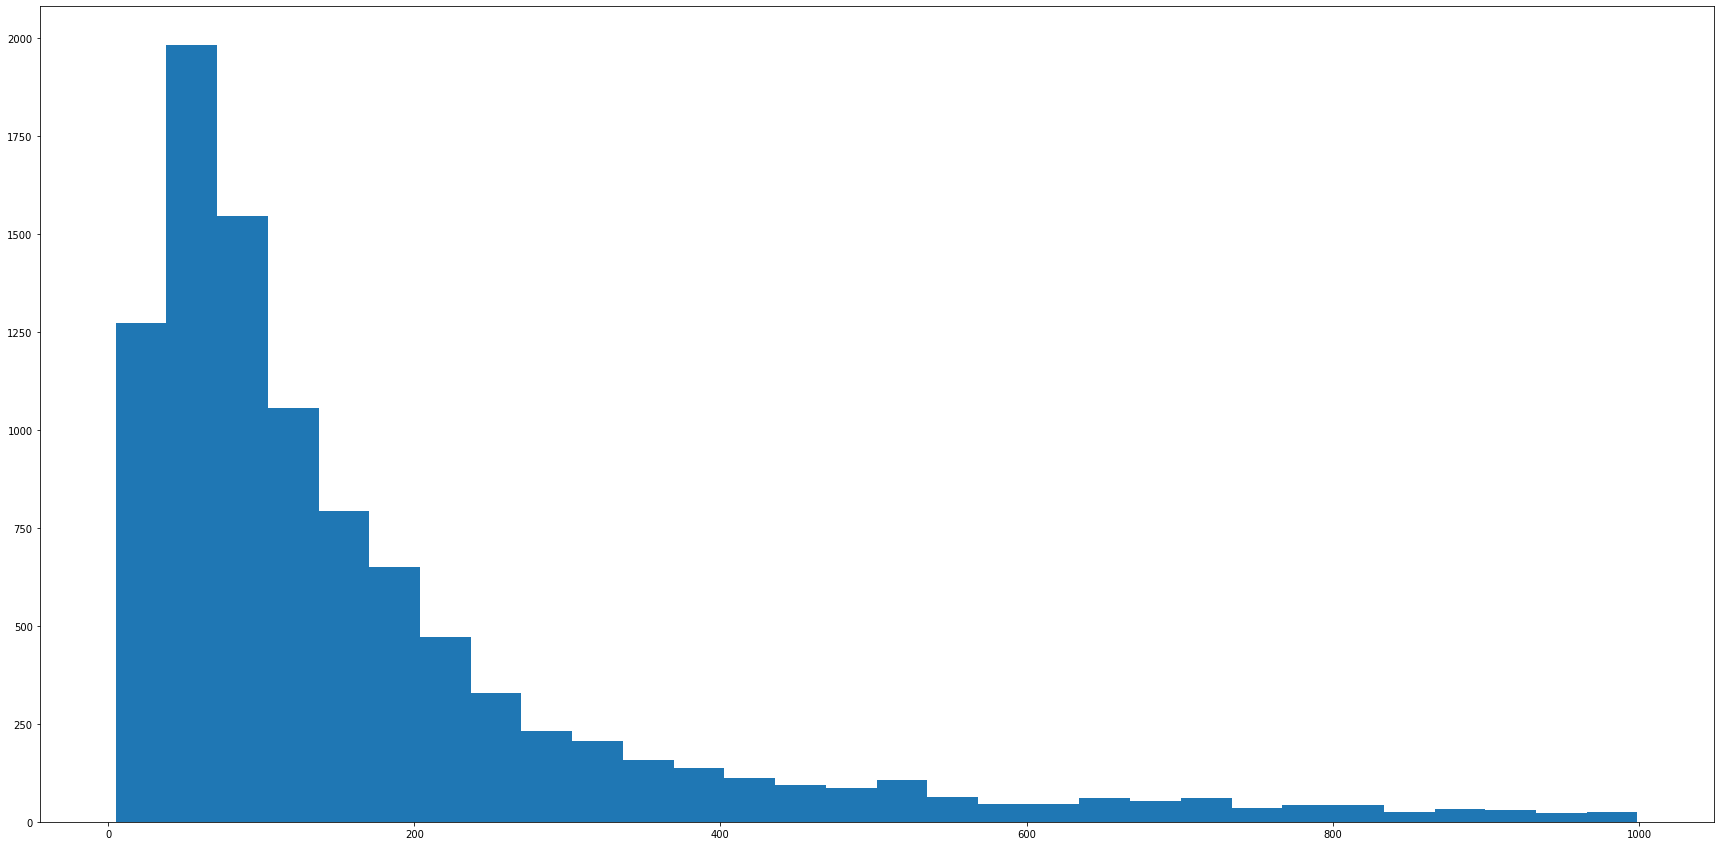

In [44]:
import matplotlib.pyplot as plt

print(df.describe())
tmp = df['len']
plt.figure(figsize=(30, 15))
plt.hist(tmp[tmp < 1000], bins=30)
plt.show()

In [24]:
text

'https://www.facebook.com/nuocxavaithailan - -chuyên phân phối sỉ và lẻ các loại nứơc xả vải thái lan cho các đại lý , hộ gia đình sử dụng + comfort thai lan : 650ml /gói giá bán 25k + daysoff thai lan : 700ml /gói giá bán 23k + hygiene thái lan : 3500ml / can giá bán 125k giao hàng tận nơi ( miễn phí ) trong tphcm ( số lựợng 3 gói trở lên ) có giá đại lý cho ngừoi tiêu dùng khi lấy số lựơng lớn call me 0909958182'

In [26]:
re.sub(r'http\S+', '', text, flags=re.MULTILINE)

' - -chuyên phân phối sỉ và lẻ các loại nứơc xả vải thái lan cho các đại lý , hộ gia đình sử dụng + comfort thai lan : 650ml /gói giá bán 25k + daysoff thai lan : 700ml /gói giá bán 23k + hygiene thái lan : 3500ml / can giá bán 125k giao hàng tận nơi ( miễn phí ) trong tphcm ( số lựợng 3 gói trở lên ) có giá đại lý cho ngừoi tiêu dùng khi lấy số lựơng lớn call me 0909958182'